In [1]:
import matplotlib.pyplot as plt

def plot_metrics(metrics_dict):
    """
    Plots the training metrics including loss on the left, 
    and other metrics like accuracy, precision, recall, f1, auc on the right.
    
    Args:
    metrics_dict (dict): A dictionary containing metrics with 'loss' as a key and the rest of the metrics like accuracy, precision, recall, f1, auc.
    """
    
    epochs = list(range(1, len(metrics_dict['loss']) + 1))

    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Plot Loss on the left y-axis
    ax1.plot(epochs, metrics_dict['loss'], label='Loss', color='blue', linewidth=2)
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')
    ax1.set_title('Loss and Other Metrics over Epochs')

    # Create a second y-axis for the other metrics
    ax2 = ax1.twinx()  
    ax2.plot(epochs, metrics_dict['accuracy'], label='Accuracy', color='green', linestyle='--')
    ax2.plot(epochs, metrics_dict['precision'], label='Precision', color='orange', linestyle='--')
    ax2.plot(epochs, metrics_dict['recall'], label='Recall', color='red', linestyle='--')
    ax2.plot(epochs, metrics_dict['f1_score'], label='F1 Score', color='purple', linestyle='--')
    ax2.plot(epochs, metrics_dict['auc'], label='AUC', color='brown', linestyle='--')

    ax2.set_ylabel('Metrics', color='black')
    ax2.tick_params(axis='y')

    # Add legends
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')

    plt.tight_layout()
    plt.show()


In [2]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize

import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import scipy.sparse
import json

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import classification_report, confusion_matrix

import torch
from torch_geometric.data import Data
from torch.optim import Adam
import torch.nn.functional as F


# 1. Apply SMOTE
def apply_smote(X, Y):
    smote = SMOTE(random_state=42)
    X_resampled, Y_resampled = smote.fit_resample(X, Y)
    return X_resampled, Y_resampled


class ANN_MultiClassClassifier(torch.nn.Module):
    def __init__(self, num_features, hidden_channels=128, num_classes=4):  # Set num_classes to 4
        super(ANN_MultiClassClassifier, self).__init__()
        # Fully connected layers for multi-class classification
        self.fc1 = nn.Linear(num_features, hidden_channels)
        self.fc2 = nn.Linear(hidden_channels, hidden_channels // 2)
        self.fc3 = nn.Linear(hidden_channels // 2, num_classes)  # Output layer for 4-class classification

    def forward(self, data):
        # Forward pass through the fully connected layers
        x = F.relu(self.fc1(data.x))  # Input features are passed to the ANN
        x = F.relu(self.fc2(x))
        x = self.fc3(x)  # Final output without softmax (logits for multi-class classification)
        return x


# Transform Y for Multi-Class Classification
def transform_y_for_multi_class(Y):
    # If Y is a numpy array, convert it to a PyTorch tensor
    if isinstance(Y, np.ndarray):
        Y = torch.tensor(Y, dtype=torch.float)
    
    # Convert LoS into 4 classes:
    # 0 if LoS <= 1 (one day or less),
    # 1 if LoS > 1 and LoS <= 3 (three days),
    # 2 if LoS > 3 and LoS <= 7 (up to a week),
    # 3 if LoS > 7 (more than a week)
    return torch.where(Y <= 1, 0,
                       torch.where(Y <= 3, 1,
                                   torch.where(Y <= 7, 2, 3)))


def load_dict_from_pickle(filename):
    with open(filename, 'rb') as file:
        loaded_dict = pickle.load(file)
    return loaded_dict

def evaluate_multi_class(model, data, mask, num_classes):
    model.eval()
    with torch.no_grad():
        logits = model(data)[mask]
        preds = torch.argmax(logits, dim=1).cpu().numpy()  # Get class predictions
        true_labels = data.y[mask].cpu().numpy()

        # Binarize the true labels for multi-class AUC calculation
        true_labels_binarized = label_binarize(true_labels, classes=np.arange(num_classes))

        # Get class probabilities by applying softmax to the logits
        probs = torch.softmax(logits, dim=1).cpu().numpy()

        try:
            # Calculate AUC for each class and then macro-average
            auc = roc_auc_score(true_labels_binarized, probs, average='macro', multi_class='ovr')
        except ValueError:
            # Handle cases where AUC cannot be calculated
            auc = None

        accuracy = accuracy_score(true_labels, preds)
        precision = precision_score(true_labels, preds, average='weighted')
        recall = recall_score(true_labels, preds, average='weighted')
        f1 = f1_score(true_labels, preds, average='weighted')

        return {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'auc': auc  # AUC may be None if not computable
        }


def prepare_masks(X, Y, train_size=0.8, val_size=0.1, test_size=0.1, random_state=42):
    from sklearn.model_selection import train_test_split
    import torch
    
    # Ensure the sizes are correct
    assert len(X) == len(Y), "X and Y must have the same length"
    
    # Create indices for the full dataset
    indices = np.arange(len(X))
    
    # First, split into train and temp (val + test)
    train_indices, temp_indices = train_test_split(indices, train_size=train_size, random_state=random_state)
    
    # Then split the temp set into validation and test sets
    val_indices, test_indices = train_test_split(temp_indices, test_size=test_size/(test_size + val_size), random_state=random_state)
    
    # Initialize masks for all data points
    train_mask = torch.zeros(len(X), dtype=torch.bool)
    val_mask = torch.zeros(len(X), dtype=torch.bool)
    test_mask = torch.zeros(len(X), dtype=torch.bool)

    # Set the appropriate indices to True
    train_mask[train_indices] = True
    val_mask[val_indices] = True
    test_mask[test_indices] = True

    return train_mask, val_mask, test_mask

def train(model, data, train_mask, optimizer, criterion):
    model.train()
    optimizer.zero_grad()
    out = model(data)  # Forward pass
    loss = criterion(out[train_mask], data.y[train_mask].long())  # Compute loss
    loss.backward()  # Backward pass
    optimizer.step()  # Update weights
    return loss.item()

def load_data(file_path, device):
    # Load data
    X = torch.load(f'{file_path}/X.pt')
    Y = torch.load(f'{file_path}/Y.pt')
    
    if isinstance(X, scipy.sparse.csr_matrix) or isinstance(X, scipy.sparse.csr_array):
        X = torch.tensor(X.toarray(), dtype=torch.float).to(device)  # Convert sparse matrix to dense and then to tensor
    else:
        X = X.to(device)

    Y = transform_y_for_multi_class(Y)
    Nodes = load_dict_from_pickle(f'{file_path}/Nodes.pkl')

    # Subset to patient nodes (assuming node name starts with 'V')
    indeces = {p: i for i, p in enumerate(Nodes)}
    visit_indeces = [indeces[v] for v in Nodes if v[0] == 'V']

    X = X[visit_indeces]
    Y = Y[visit_indeces]

    return X, Y, Nodes


def main(file_path, num_epochs, num_classes, lr=1e-5):
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    X, Y, Nodes = load_data(file_path, device)

    # Apply SMOTE to oversample the minority class
    X_resampled, Y_resampled = apply_smote(X, Y)

    # Convert resampled X and Y back to tensors
    X_resampled = torch.tensor(X_resampled, dtype=torch.float).to(device)
    Y_resampled = torch.tensor(Y_resampled, dtype=torch.float).to(device)

    data = Data(x=X_resampled, y=Y_resampled)
    
    # Prepare masks (you can apply the new prepare_masks on the resampled data)
    train_mask, val_mask, test_mask = prepare_masks(X_resampled, Y_resampled)
    data.train_mask = train_mask.to(device)
    data.val_mask = val_mask.to(device)
    data.test_mask = test_mask.to(device)

    num_features = X_resampled.size(1)
    
    # Initialize the ANN model
    model = ANN_MultiClassClassifier(num_features, hidden_channels=128, num_classes=num_classes).to(device)

    # Optimizer and criterion (for multi-class classification)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=5e-4)

    # Class imbalance adjustment with CrossEntropyLoss
    criterion = torch.nn.CrossEntropyLoss()

    print(f"Class distribution: {torch.sum(data.y == 0)}, {torch.sum(data.y == 1)}")
    metrics_dict = {'loss': [],'accuracy': [],'precision': [],'recall': [],'f1_score': [],'auc': []}
    
    # Training loop
    for epoch in range(1, num_epochs + 1):
        model.train()
        optimizer.zero_grad()
        out = model(data).squeeze(1)  # Forward pass
        
        # Convert target labels to Long type for CrossEntropyLoss
        loss = criterion(out[data.train_mask], data.y[data.train_mask].long())  # Compute loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update weights

        # Evaluate on validation set
        val_metrics = evaluate_multi_class(model, data, val_mask, num_classes)

        # Save the metrics for this epoch
        metrics_dict['loss'].append(loss.item())
        metrics_dict['accuracy'].append(val_metrics['accuracy'])
        metrics_dict['precision'].append(val_metrics['precision'])
        metrics_dict['recall'].append(val_metrics['recall'])
        metrics_dict['f1_score'].append(val_metrics['f1_score'])
        
        if val_metrics['auc'] is not None:
            metrics_dict['auc'].append(val_metrics['auc'])
        else:
            metrics_dict['auc'].append(0)
    
        # print(f'Epoch {epoch}/{num_epochs}, Loss: {loss.item():.4f}, Accuracy: {val_metrics["accuracy"]:.4f}, Precision: {val_metrics["precision"]:.4f}, Recall: {val_metrics["recall"]:.4f}, F1: {val_metrics["f1_score"]:.4f}, AUC: {val_metrics["auc"]}')

    # Final evaluation on test set
    test_metrics = evaluate_multi_class(model, data, test_mask, num_classes)
    print(json.dumps(test_metrics, indent=4))
    return metrics_dict


# Set parameters and run the main training process
num_Labels = 203
DISEASE_FILE = 'infectious'
saving_path = f'../Data/{num_Labels}_Diagnoses/{DISEASE_FILE}'
num_epochs = 250
results = main(saving_path, num_epochs, num_classes=4, lr=1e-2)


/tmp/ipykernel_795845/12880670.py:139: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  X = torch.load(f'{file_path}/X.pt')
/tmp/ipykernel_795845/12880670.py:140: FutureWarning

Class distribution: 11670, 11670


/home/almusawiaf/.local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{
    "accuracy": 0.7742073693230506,
    "precision": 0.764295828894002,
    "recall": 0.7742073693230506,
    "f1_score": 0.7664789737827576,
    "auc": 0.925956229251586
}


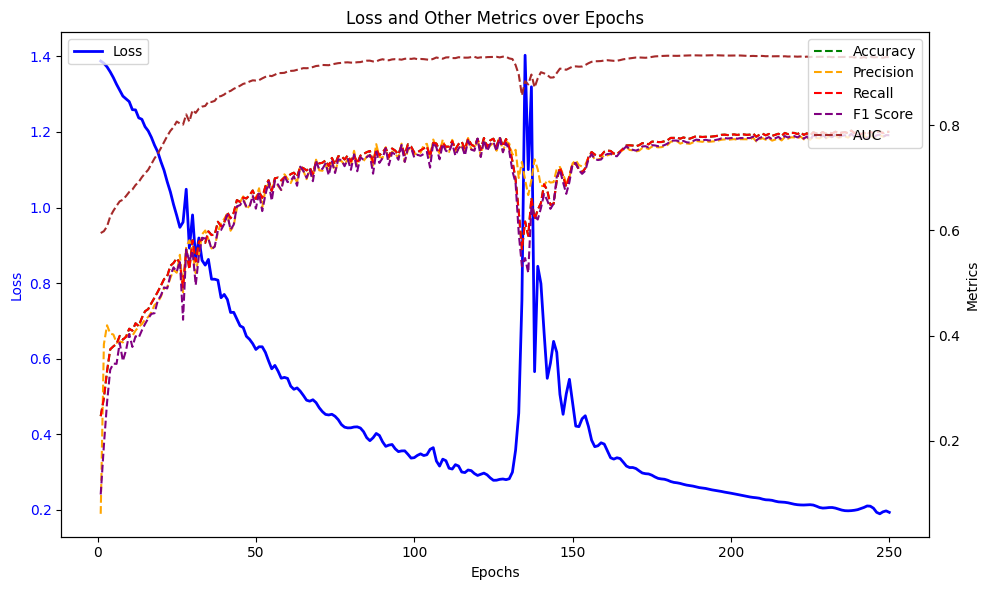

In [3]:
plot_metrics(results)